**Checking GPU in the system**

In [1]:
import tensorflow as tf
from tensorflow import keras
print("Number of GPUS : ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()

Number of GPUS :  1


True

**Loading the dataset from Google Drive**

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
Path = 'dataset'

Using VGG16 model (transfer learning technique)

In [4]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from PIL import Image
from tqdm import tqdm

In [5]:
IMAGE_SIZE = [224, 224]

train_path = 'chest_xray/train'
valid_path = 'chest_xray/valid'
test_path = 'chest_xray/test'

In [6]:
import glob

In [7]:
import cv2

In [8]:

x_train = []
y_train = []
x_test = []
y_test = []
# val=[]


for images in tqdm(glob.iglob(f'{train_path}/NORMAL/*')):
#   x_train.append(cv2.imread(images, 0))
  img = cv2.imread(images, 0)
  x_train.append(cv2.resize(img, (224, 224)))
  y_train.append(0)

for images in glob.iglob(train_path+'/PNEUMONIA/*'):
  img = cv2.imread(images, 0)
  x_train.append(cv2.resize(img, (224, 224)))
  y_train.append(1)

1341it [00:19, 67.77it/s]


In [9]:
type(np.array([]))

numpy.ndarray

In [10]:
for i in range(len(x_train)):
    x_train[i] = np.asarray(x_train[i])


In [11]:
x_train = np.asarray(x_train, dtype=int)
y_train = np.asarray(y_train,dtype=int)

In [12]:
x_train.shape

(5216, 224, 224)

In [13]:
print(len(x_train))

5216


In [14]:
print(type(x_train))

<class 'numpy.ndarray'>


In [15]:
print(x_train.shape, y_train.shape)

(5216, 224, 224) (5216,)


In [16]:
x_train[0].shape

(224, 224)

In [17]:
print(x_train[0])

[[ 24  20  19 ...  95  94  95]
 [ 22  22  17 ...  91  95  95]
 [ 24  21  20 ...  93  93  92]
 ...
 [ 29  29  29 ...  61  59  59]
 [ 34  33  35 ...  79  81  82]
 [ 46  45  45 ... 108 113 110]]


In [18]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [19]:
print(np.unique(y_train).size)

2


In [20]:
x_train = np.reshape(x_train, (5216, 50176))

In [21]:
rus = RandomOverSampler(random_state=0)
X_res, y_res = rus.fit_resample(x_train, y_train)
# rus.fit(x_train, y_train)
# X_resampled, y_resampled = rus.sample(x_train, y_train)

In [22]:
unique, count = np.unique(y_res, return_counts=True)
count

array([3875, 3875], dtype=int64)

In [23]:
X_res.shape

(7750, 50176)

In [25]:
X_res = np.reshape(X_res,(7750, 224, 224))
X_res[0]

array([[ 24,  20,  19, ...,  95,  94,  95],
       [ 22,  22,  17, ...,  91,  95,  95],
       [ 24,  21,  20, ...,  93,  93,  92],
       ...,
       [ 29,  29,  29, ...,  61,  59,  59],
       [ 34,  33,  35, ...,  79,  81,  82],
       [ 46,  45,  45, ..., 108, 113, 110]])

In [28]:
X_res.shape

(7750, 224, 224)

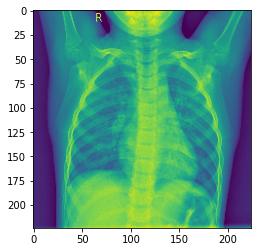

In [26]:
plt.imshow(X_res[0])

In [27]:
for i in range(len(X_res)):
    t = X_res[i][:]
    img2 = np.zeros((224,224,3))
    img2[:,:,0] = t
    img2[:,:,1] = t
    img2[:,:,2] = t
    cv2.imwrite('IMG'+str(i) +' ' + str(y_res[i]) + '.jpg',img2)

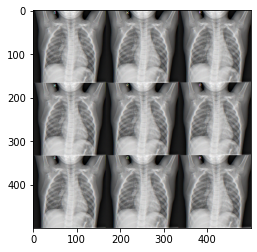

In [7]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [8]:
for layer in vgg.layers:
    layer.trainable = False

In [9]:
folders = glob(train_path+'/*')

In [24]:
print(len(folders))

2


In [10]:
x = Flatten()(vgg.output)

In [11]:
prediction = Dense(len(folders), activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [13]:
optimizer = keras.optimizers.Adam(lr=0.000001)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizer,
  metrics=['accuracy']
)

In [15]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5221 images belonging to 2 classes.


In [20]:
training_set.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [26]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (150, 150),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [29]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=25,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/25
164/164 [==============================] - 90s 548ms/step - loss: 0.0885 - accuracy: 0.9680 - val_loss: 0.2813 - val_accuracy: 0.8974
Epoch 2/25
164/164 [==============================] - 88s 538ms/step - loss: 0.0956 - accuracy: 0.9640 - val_loss: 0.2798 - val_accuracy: 0.8974
Epoch 3/25
164/164 [==============================] - 89s 542ms/step - loss: 0.0931 - accuracy: 0.9657 - val_loss: 0.2802 - val_accuracy: 0.8974
Epoch 4/25
164/164 [==============================] - 91s 553ms/step - loss: 0.0909 - accuracy: 0.9655 - val_loss: 0.2799 - val_accuracy: 0.8974
Epoch 5/25
164/164 [==============================] - 89s 542ms/step - loss: 0.0944 - accuracy: 0.9671 - val_loss: 0.2777 - val_accuracy: 0.8974
Epoch 6/25
164/164 [==============================] - 88s 536ms/step - loss: 0.0948 - accuracy: 0.9636 - val_loss: 0.2773 - val_accuracy: 0.8974
Epoch 7/25
164/164 [==============================] - 90s 552ms/step - loss: 0.0932 - accuracy: 0.9657 - val_loss: 0.2772 - val_ac

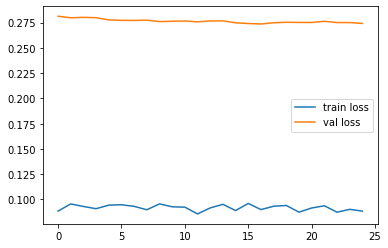

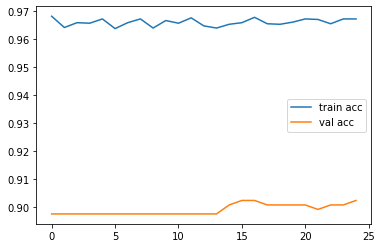

<Figure size 432x288 with 0 Axes>

In [30]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

acc = r.history['accuracy']
val_acc = r.history['val_accuracy']

loss = r.history['loss']
val_loss = r.history['val_loss']

In [19]:
import tensorflow as tf

from keras.models import load_model

modelPath = 'drive/My Drive/dataset/modelWt.h5'
model.save('drive/My Drive/dataset/modelWt.h5')

In [20]:
from keras.models import load_model
from keras_preprocessing import image
from keras.applications.vgg16 import preprocess_input

model  = load_model(modelPath)

img  = image.load_img('drive/My Drive/dataset/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg' , target_size=(150,150))

x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)


1/1 [==============================] - 1s 732ms/step
